## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

# Step 1: Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Model
from keras import regularizers


from numpy.random import seed

import tensorflow as tf
tf.get_logger().setLevel('ERROR')



# Rest of your code...


# Step 2: Set Random Seed

In [2]:
# Define the random seed value
seed_value = 10

# Set random seed for TensorFlow
tf.random.set_seed(seed_value)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

# Step 3: Load and Preprocess Sensor Data

In [3]:
# load, average and merge sensor samples
data_dir = 'Sensor Data\Bearing_Sensor_Data_pt1'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

# Step 4: Time Series Data Handling

In [4]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (565, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [5]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (121, 4)


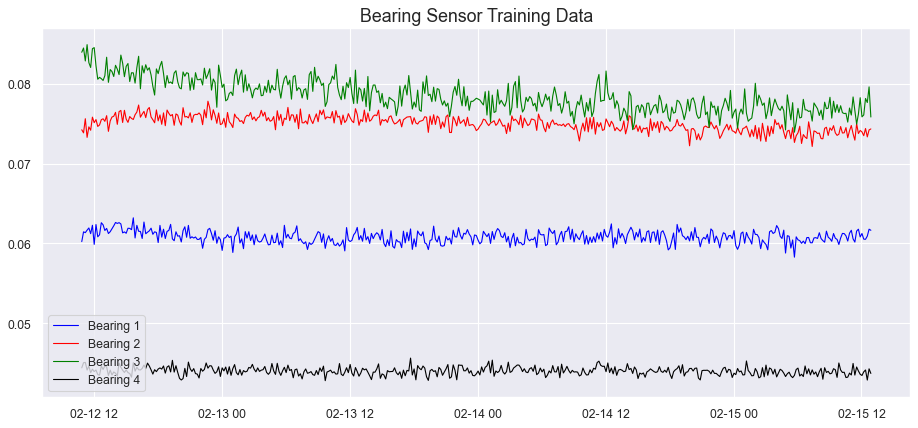

In [6]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

# Step 6: Data Transformation

In [7]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

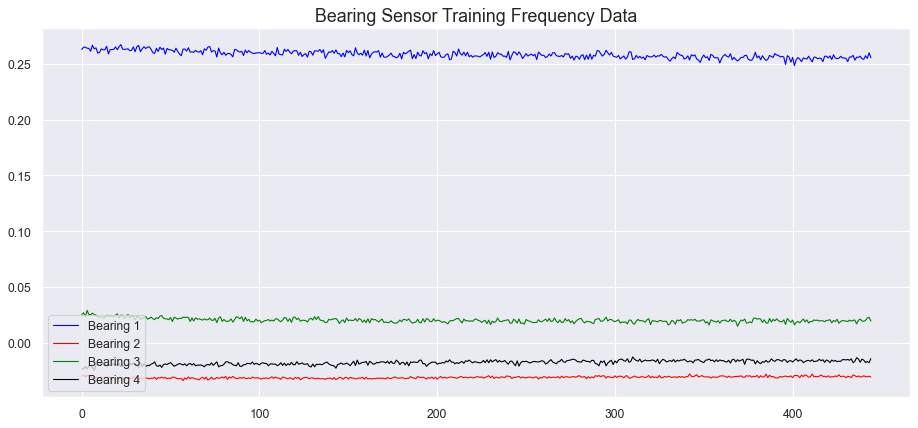

In [8]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

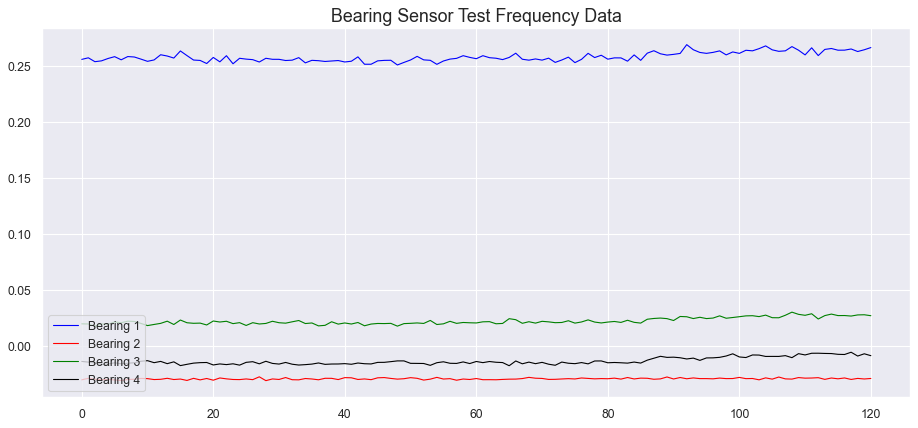

In [9]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

# Step 7: Data Normalization

In [10]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [11]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (121, 1, 4)


# Step 8: Define and Train an Autoencoder Model

In [12]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

# What is autoencoder?

# **Why it's Good:**

In [13]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 5s 20ms/step - loss: 0.4454 - val_loss: 0.3190
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.3812 - val_loss: 0.2455
Epoch 3/100
43/43 [==============================] - 0s 4ms/step - loss: 0.2909 - val_loss: 0.1621
Epoch 4/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1621 - val_loss: 0.1684
Epoch 5/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1152 - val_loss: 0.1404
Epoch 6/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1073 - val_loss: 0.1225
Epoch 7/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1035 - val_loss: 0.1146
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.1138
Epoch 9/100
43/43 [==============================] - 0s 7ms/step - loss: 0.1013 - val_loss: 0.1151
Epoch 10/100
43/43 [==============================] - 0s 5ms/step - loss: 0.1011 - val_loss: 0.1132
Epoch 11

43/43 [==============================] - 0s 4ms/step - loss: 0.0938 - val_loss: 0.0936
Epoch 84/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0937 - val_loss: 0.0928
Epoch 85/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0936 - val_loss: 0.0921
Epoch 86/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0935 - val_loss: 0.0937
Epoch 87/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0941 - val_loss: 0.0930
Epoch 88/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0942 - val_loss: 0.0928
Epoch 89/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0937 - val_loss: 0.0925
Epoch 90/100
43/43 [==============================] - 0s 4ms/step - loss: 0.0937 - val_loss: 0.0918
Epoch 91/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0937 - val_loss: 0.0917
Epoch 92/100
43/43 [==============================] - 0s 5ms/step - loss: 0.0935 - val_loss: 0.0912
Epoch 93/100


# Step 9: Visualize Training Loss

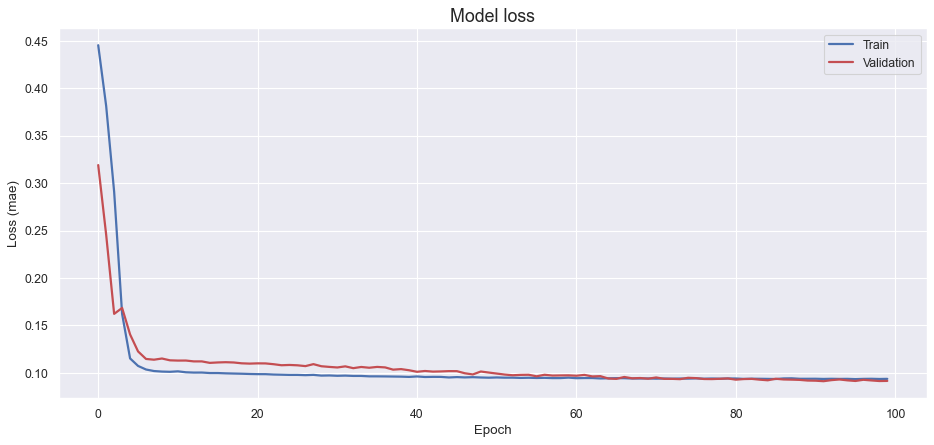

In [14]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

14/14 [==============================] - 1s 2ms/step


C:\Users\PTPL0125\AppData\Local\Temp\ipykernel_19676\3269023118.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

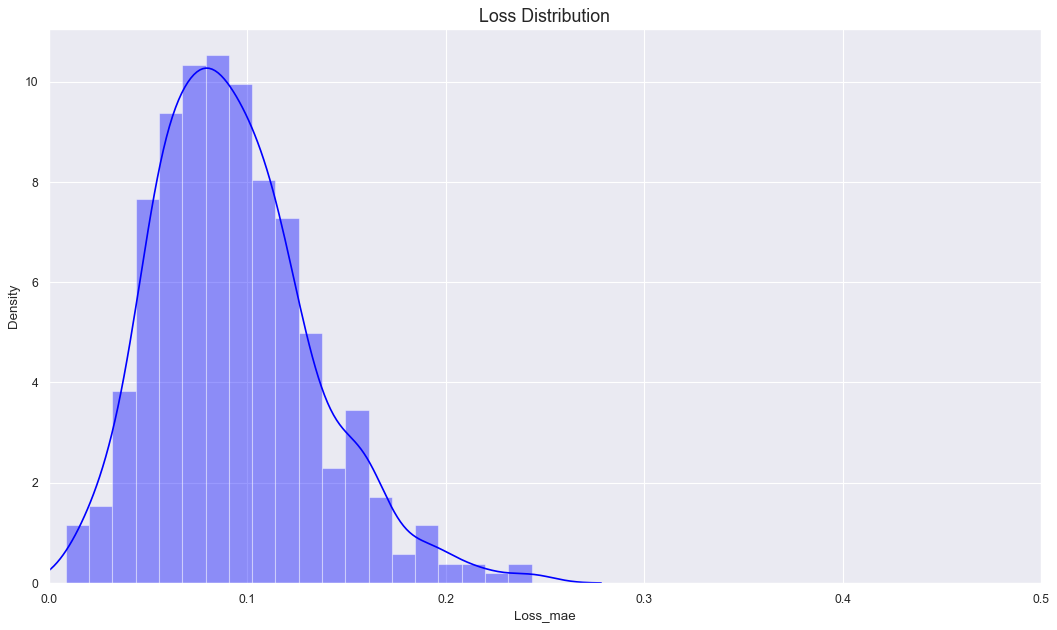

In [15]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [16]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

4/4 [==============================] - 0s 7ms/step


,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.094793,0.275,False
2004-02-15 13:02:39,0.171477,0.275,False
2004-02-15 13:12:39,0.068407,0.275,False
2004-02-15 13:22:39,0.053026,0.275,False
2004-02-15 13:32:39,0.039579,0.275,False


In [17]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

14/14 [==============================] - 0s 2ms/step


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<Axes: >

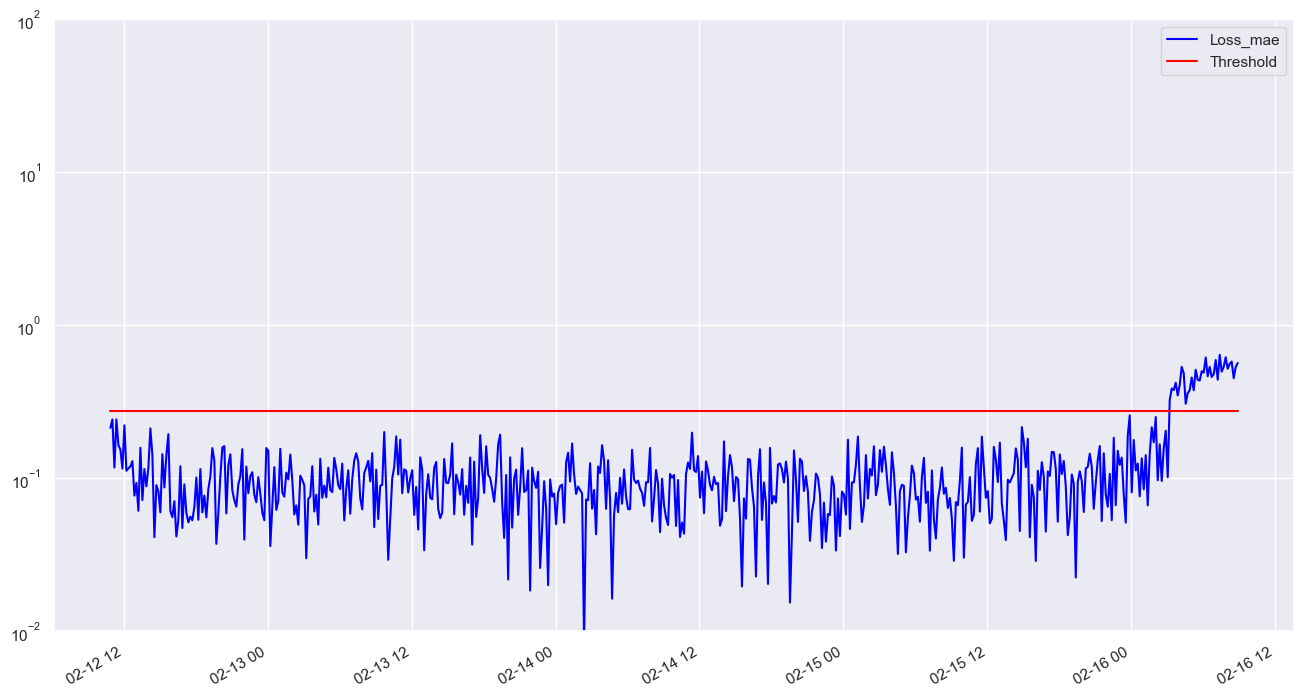

In [18]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [19]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved


# Live Prediction

In [21]:
# Define the number of features in your data
num_features = 4  # Replace with the actual number of features in your data
threshold = 0.275

def generate_random_data():
    # Generate random data as an example
    data_point = np.random.rand(1, num_features)  # Replace with your data source
    # Add an extra dimension for the time step
    return data_point.reshape(1, 1, num_features)

# ...

# In your web application, loop to continuously generate data and detect anomalies
while True:
    new_data = generate_random_data()
    reconstruction = model.predict(new_data)
    loss = np.mean(np.abs(new_data - reconstruction))
    
    if loss > threshold:
        # Anomaly detected, notify the user or update the UI
        print("Anomaly detected!")

    # Update UI or send data to the frontend for visualization


1/1 [==============================] - 0s 18ms/step
Anomaly detected!
1/1 [==============================] - 0s 17ms/step
Anomaly detected!
1/1 [==============================] - 0s 22ms/step
Anomaly detected!
1/1 [==============================] - 0s 19ms/step
Anomaly detected!
1/1 [==============================] - 0s 16ms/step
Anomaly detected!
1/1 [==============================] - 0s 14ms/step
Anomaly detected!
1/1 [==============================] - 0s 34ms/step
Anomaly detected!
1/1 [==============================] - 0s 30ms/step
Anomaly detected!
1/1 [==============================] - 0s 34ms/step
Anomaly detected!
1/1 [==============================] - 0s 27ms/step
Anomaly detected!
1/1 [==============================] - 0s 16ms/step
Anomaly detected!
1/1 [==============================] - 0s 13ms/step
Anomaly detected!
1/1 [==============================] - 0s 21ms/step
Anomaly detected!
1/1 [==============================] - 0s 16ms/step
Anomaly detected!
1/1 [===============

1/1 [==============================] - 0s 16ms/step
Anomaly detected!
1/1 [==============================] - 0s 17ms/step
Anomaly detected!
1/1 [==============================] - 0s 18ms/step
Anomaly detected!
1/1 [==============================] - 0s 14ms/step
Anomaly detected!
1/1 [==============================] - 0s 15ms/step
Anomaly detected!
1/1 [==============================] - 0s 16ms/step
Anomaly detected!
1/1 [==============================] - 0s 14ms/step
Anomaly detected!
1/1 [==============================] - 0s 26ms/step
Anomaly detected!
1/1 [==============================] - 0s 18ms/step
Anomaly detected!
1/1 [==============================] - 0s 21ms/step
Anomaly detected!
1/1 [==============================] - 0s 21ms/step
Anomaly detected!
1/1 [==============================] - 0s 27ms/step
Anomaly detected!
1/1 [==============================] - 0s 15ms/step
Anomaly detected!
1/1 [==============================] - 0s 22ms/step
Anomaly detected!
1/1 [===============

KeyboardInterrupt: 

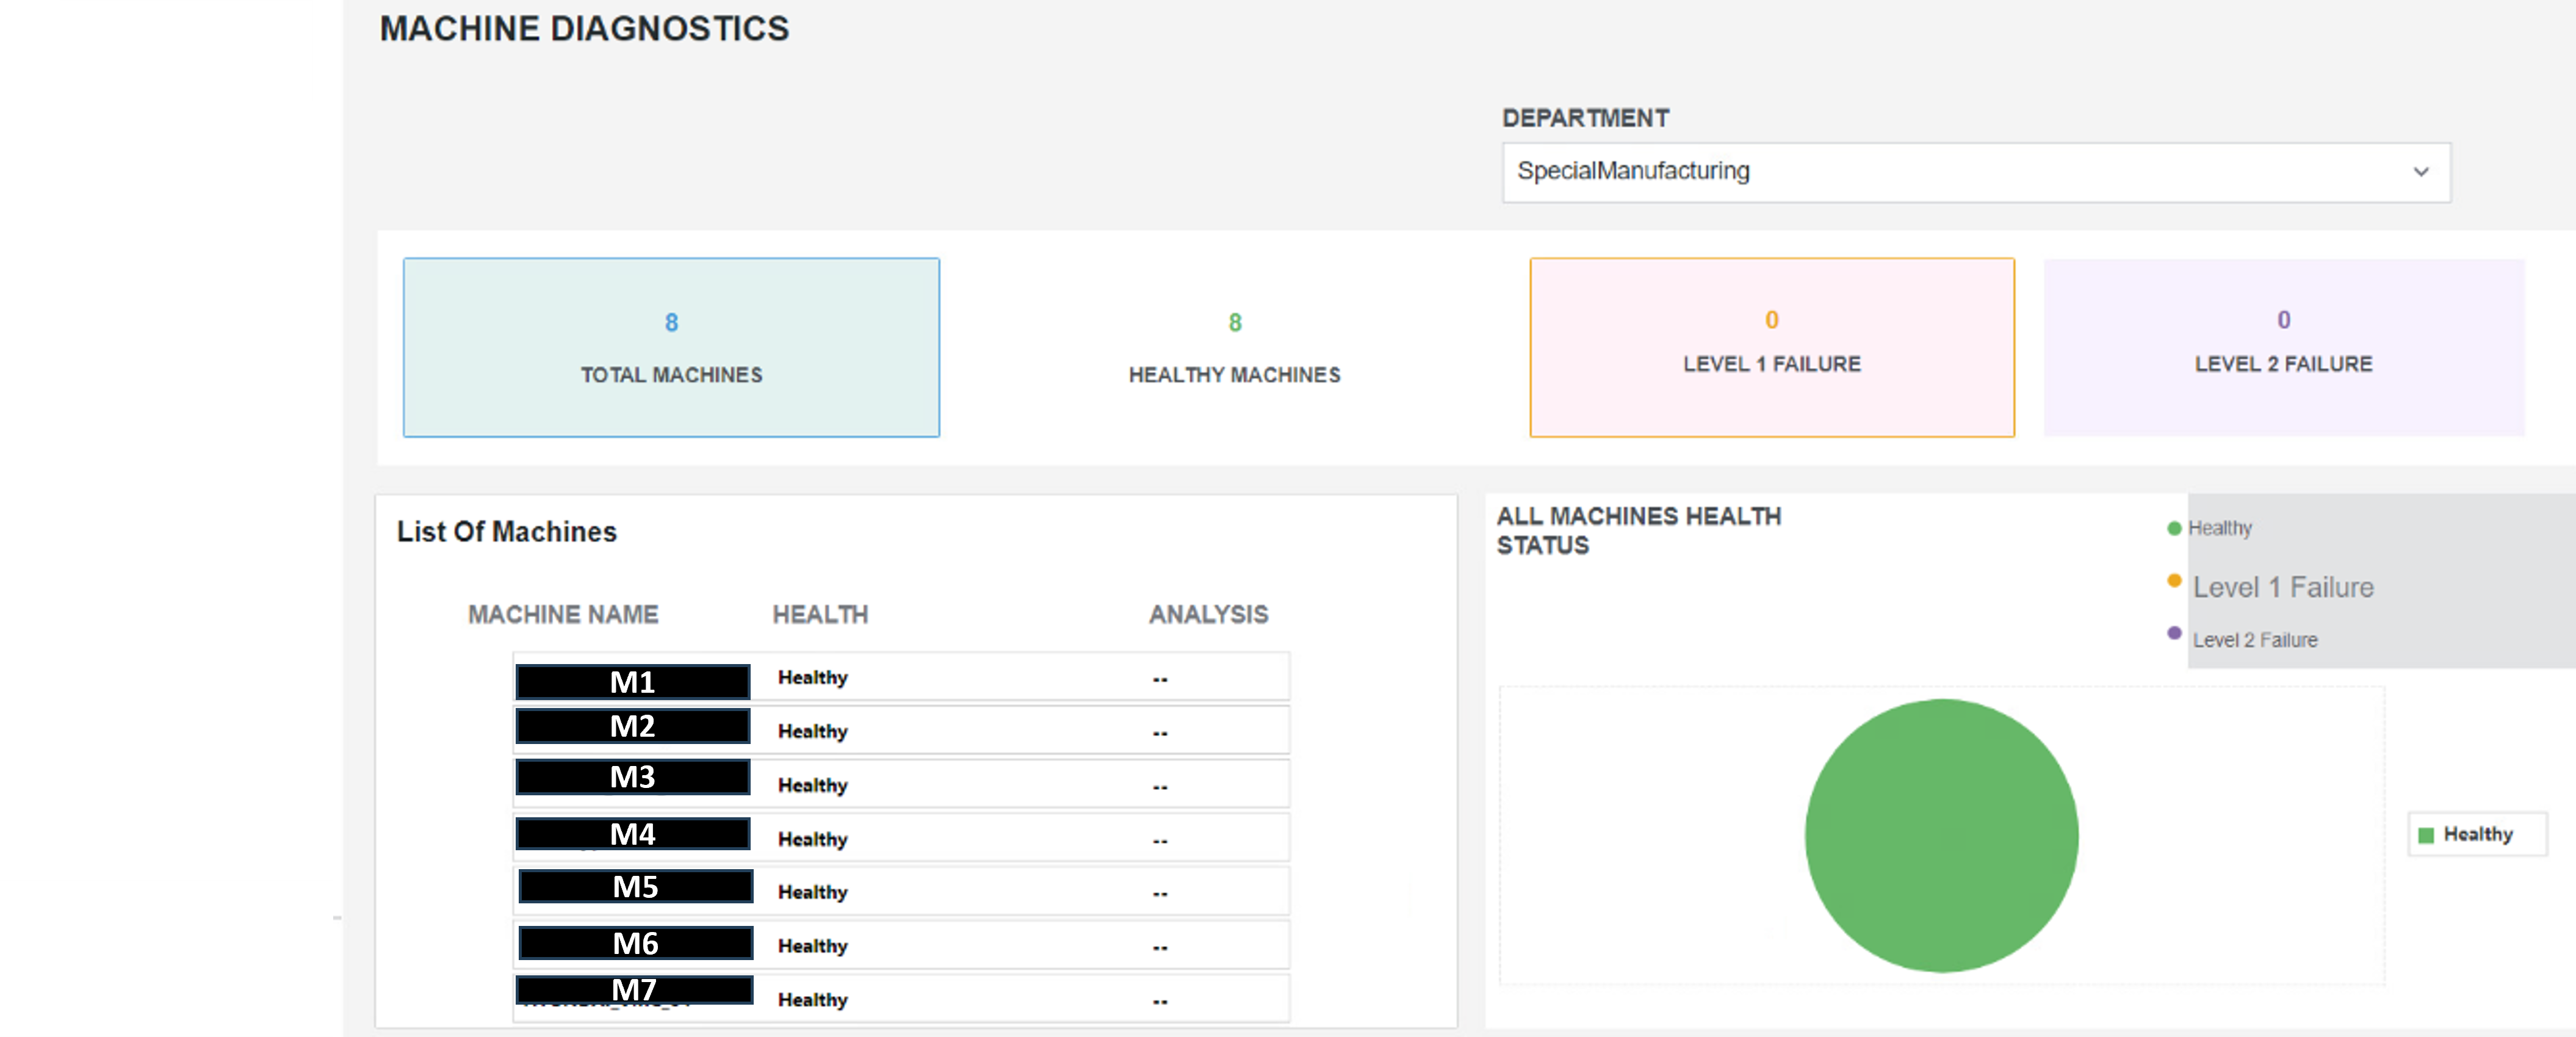

In [23]:
from IPython.display import Image

# Replace 'image_path.png' with the actual path to your image file
image_path = 'home.png'

Image(filename=image_path)

from IPython.display import Image



# Display the image
Image(filename=image_path)


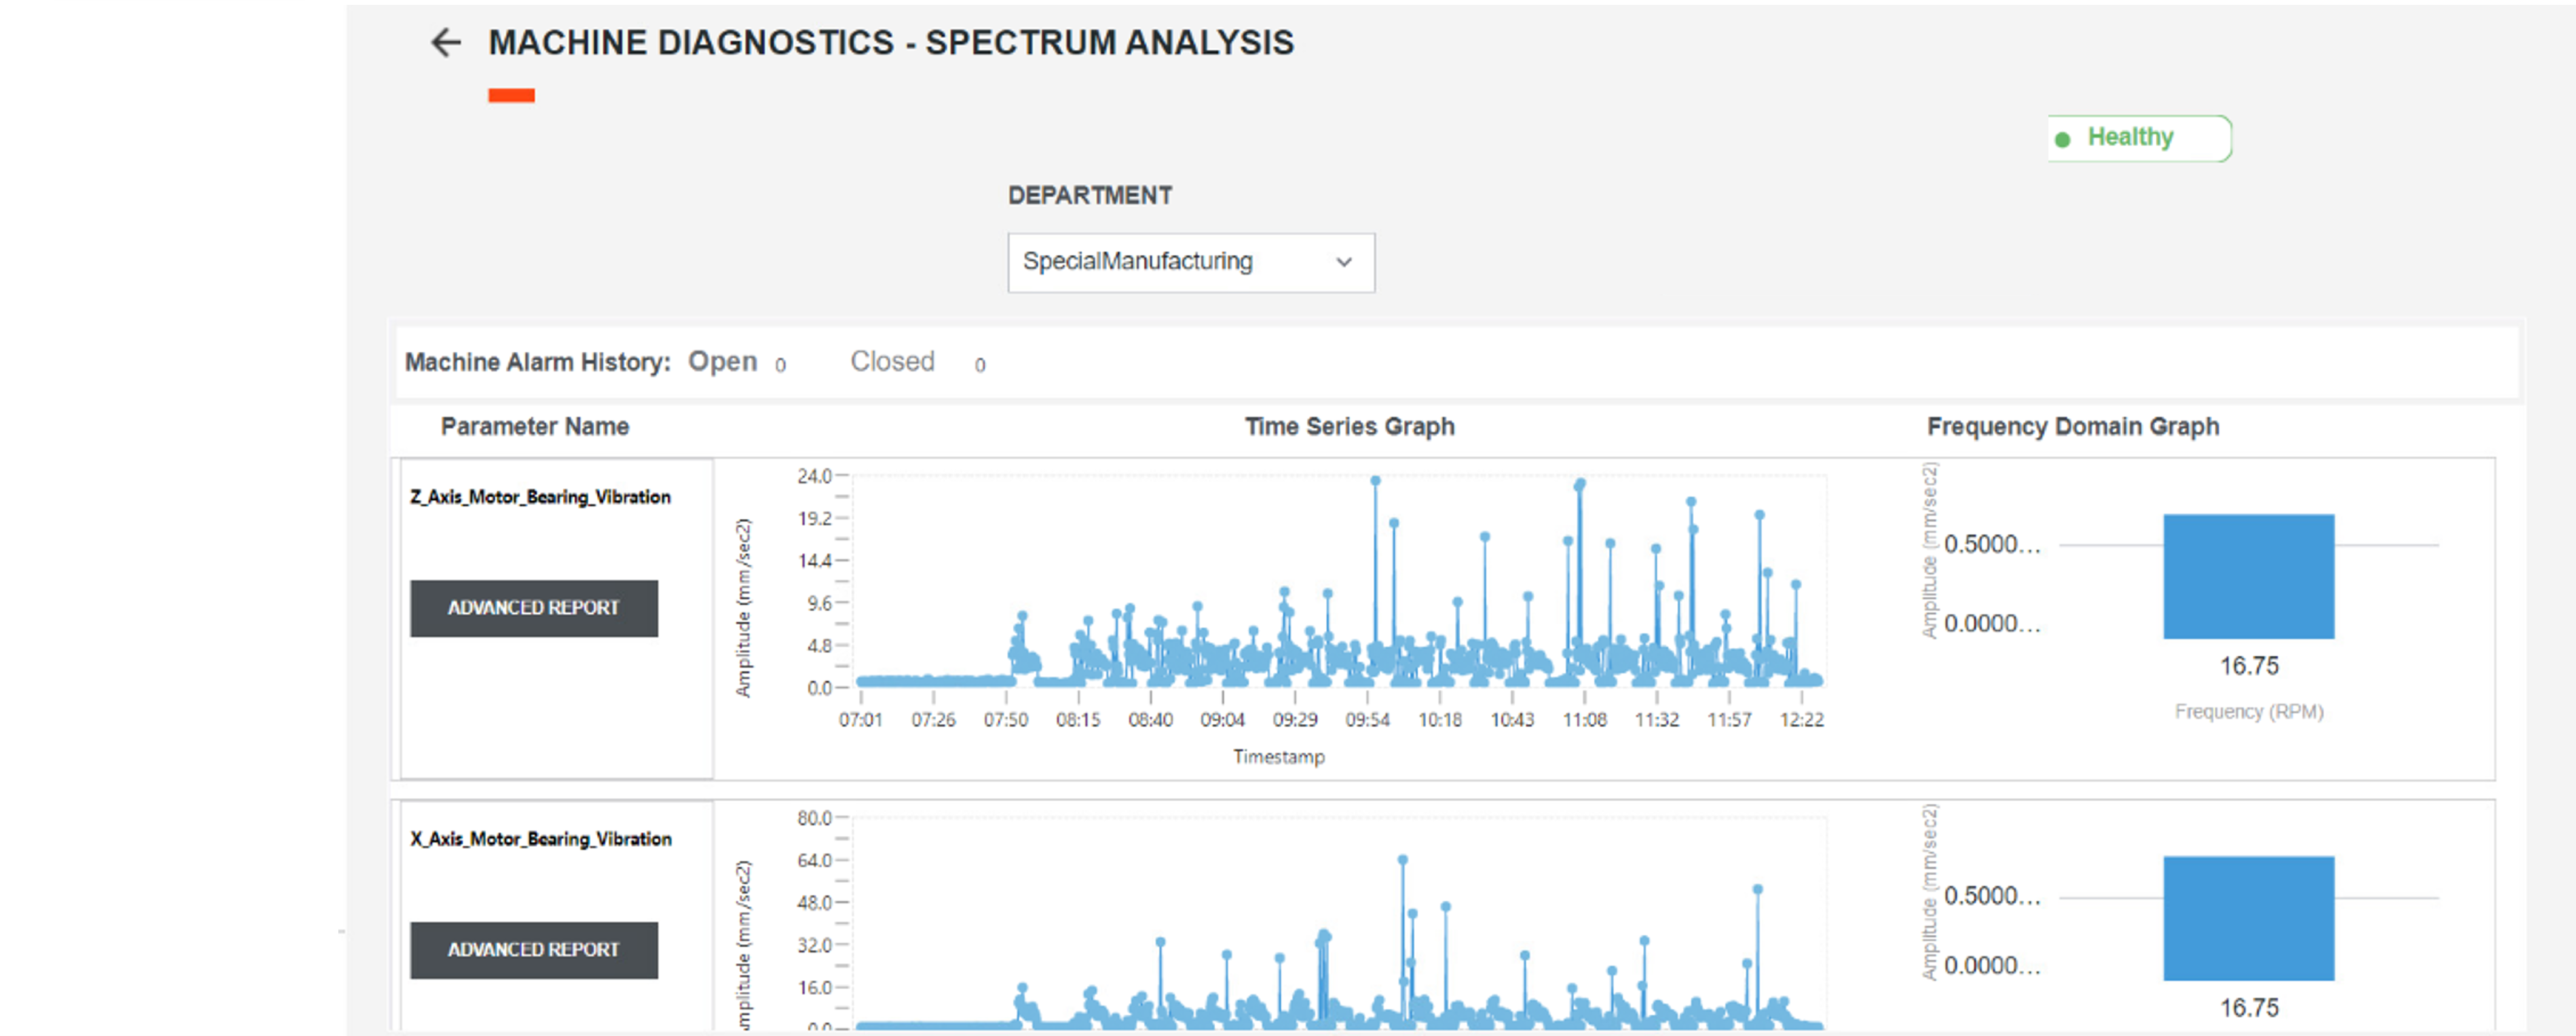

In [22]:
from IPython.display import Image

# Replace 'image_path.png' with the actual path to your image file
image_path = 'Spectrum analysis.png'

Image(filename=image_path)

from IPython.display import Image



# Display the image
Image(filename=image_path)


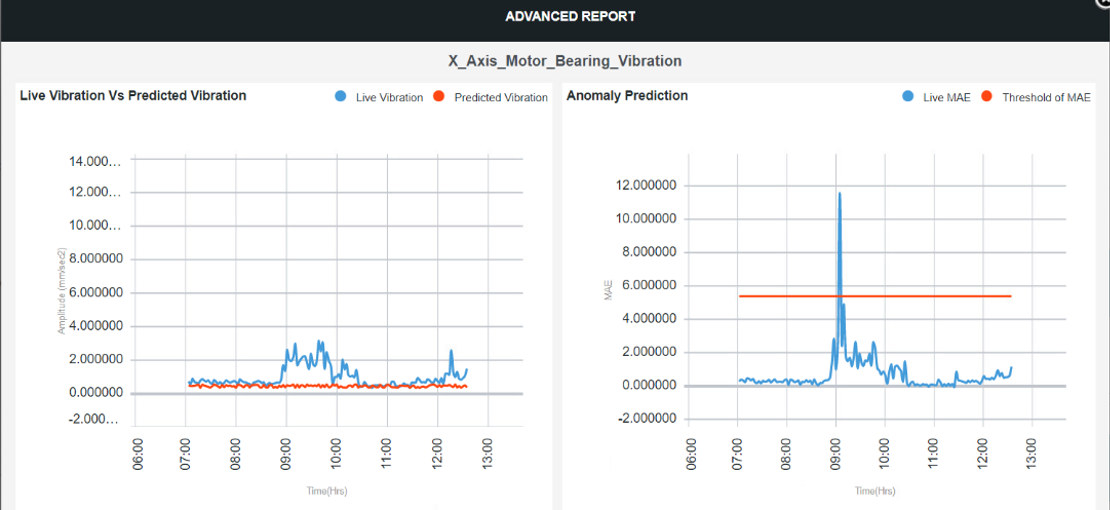

In [24]:
from IPython.display import Image

# Replace 'image_path.png' with the actual path to your image file
image_path = 'Predictive Maintenance Alert.png'

Image(filename=image_path)

from IPython.display import Image



# Display the image
Image(filename=image_path)